In [1]:
import warnings

import os
import shutil
import stat
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import Hyperband, HyperParameters
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

warnings.filterwarnings('ignore')

In [2]:
train_dir = "../b. Datasets/Garbage Dataset/Train"
test_dir = "../b. Datasets/Garbage Dataset/Test"

In [3]:
train_datagen = ImageDataGenerator(rescale=1/255.0, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   height_shift_range=0.2, 
                                   width_shift_range=0.2, 
                                   horizontal_flip=True, 
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.0)

In [4]:
train_data = train_datagen.flow_from_directory(directory=train_dir, 
                                               target_size=(80, 80),
                                               color_mode='rgb', 
                                               class_mode='categorical', 
                                               batch_size=64, 
                                               shuffle=False)

test_data = test_datagen.flow_from_directory(directory=test_dir, 
                                             target_size=(80, 80),
                                             color_mode='rgb', 
                                             class_mode='categorical', 
                                             batch_size=64, 
                                             shuffle=False)

Found 960 images belonging to 8 classes.
Found 240 images belonging to 8 classes.


In [5]:
base_model = MobileNet(weights='imagenet', 
                       input_shape=(80, 80, 3), 
                       include_top=False)
base_model.trainable = False

In [6]:
base_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 80, 80, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 40, 40, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 40, 40, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 40, 40, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 40, 40, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 40, 40, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 40, 40, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 41, 41, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 20, 20, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 20, 20, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 20, 20, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 20, 20, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 20, 20, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 20, 20, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 20, 20, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [7]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=8, activation='softmax')(x)

In [8]:
model = Model(inputs=base_model.input, outputs=x)

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 80, 80, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 40, 40, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 40, 40, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 40, 40, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 40, 40, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 40, 40, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 40, 40, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 41, 41, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 20, 20, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 20, 20, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 20, 20, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 20, 20, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 20, 20, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 20, 20, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 20, 20, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,361,096 (12.82 MB)

 Trainable params: 132,232 (516.53 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [10]:
model_checkpoint = ModelCheckpoint(filepath='garbage_classification_transfer_model.keras', 
                                   monitor='val_accuracy', 
                                   mode='max', 
                                   verbose=1, 
                                   save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               mode='max', 
                               verbose=1, 
                               patience=6)

In [11]:
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [12]:
history = model.fit(train_data, 
                    epochs=15, 
                    validation_data=test_data, 
                    batch_size=64, 
                    verbose=1, 
                    callbacks=[early_stopping, 
                               model_checkpoint])

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.1173 - loss: 6.7918
Epoch 1: val_accuracy improved from -inf to 0.30417, saving model to garbage_classification_transfer_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 377ms/step - accuracy: 0.1171 - loss: 6.6910 - val_accuracy: 0.3042 - val_loss: 2.0866
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.2141 - loss: 2.4980
Epoch 2: val_accuracy improved from 0.30417 to 0.46250, saving model to garbage_classification_transfer_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - accuracy: 0.2136 - loss: 2.4950 - val_accuracy: 0.4625 - val_loss: 1.5371
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.2765 - loss: 1.9056
Epoch 3: val_accuracy improved from 0.46250 to 0.51250, saving model to garbage_classification_transfer_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - accuracy: 0.2763 - loss: 1.9055 - val_accuracy: 0.5125 - val_loss: 1.3691
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms

In [13]:
best_model = tf.keras.models.load_model('garbage_classification_transfer_model.keras')

In [14]:
total_epochs = len(history.history['accuracy'])

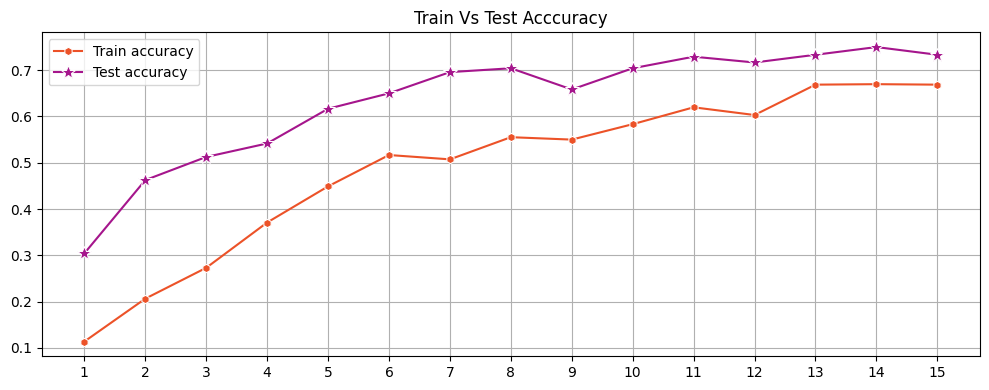

In [15]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=range(1, total_epochs+1),
             y=history.history['accuracy'], 
             label='Train accuracy', 
             color='#EC5228', 
             marker='h')
sns.lineplot(x=range(1, total_epochs+1),
             y=history.history['val_accuracy'], 
             label='Test accuracy', 
             color='#A5158C', 
             marker='*', 
             markersize=10)
plt.xticks(range(1, total_epochs + 1))
plt.title("Train Vs Test Acccuracy")
plt.grid()
plt.tight_layout()
plt.show()

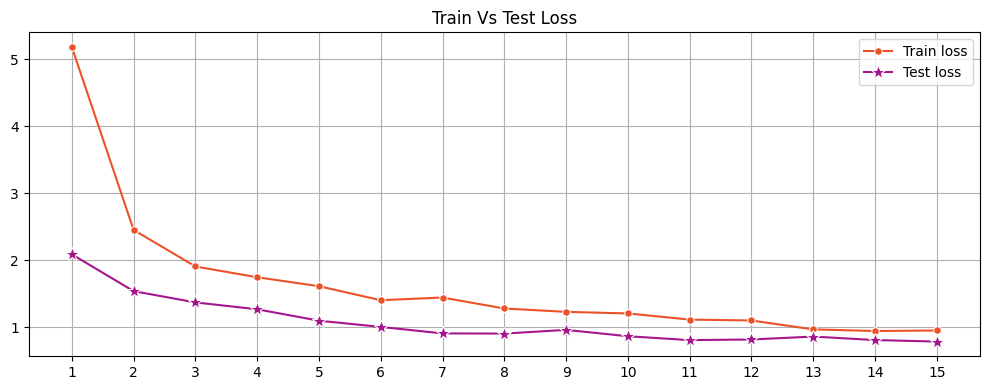

In [16]:

plt.figure(figsize=(10, 4))
sns.lineplot(x=range(1, total_epochs+1),
             y=history.history['loss'], 
             label='Train loss', 
             color='#EC5228', 
             marker='h')
sns.lineplot(x=range(1, total_epochs+1),
             y=history.history['val_loss'], 
             label='Test loss', 
             color='#A5158C', 
             marker='*', 
             markersize=10)
plt.xticks(range(1, total_epochs + 1))
plt.title("Train Vs Test Loss")
plt.grid()
plt.tight_layout()
plt.show()

In [17]:
test_prediction = best_model.predict(test_data, verbose=1) 

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step


In [18]:
test_prediction_class = np.argmax(test_prediction, axis=1)

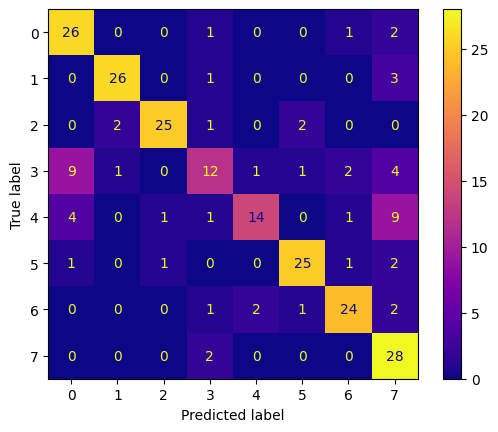

In [19]:
ConfusionMatrixDisplay(confusion_matrix(test_data.classes, test_prediction_class)).plot(cmap='plasma')

In [20]:
print(classification_report(test_data.classes, test_prediction_class))

              precision    recall  f1-score   support

           0       0.65      0.87      0.74        30
           1       0.90      0.87      0.88        30
           2       0.93      0.83      0.88        30
           3       0.63      0.40      0.49        30
           4       0.82      0.47      0.60        30
           5       0.86      0.83      0.85        30
           6       0.83      0.80      0.81        30
           7       0.56      0.93      0.70        30

    accuracy                           0.75       240
   macro avg       0.77      0.75      0.74       240
weighted avg       0.77      0.75      0.74       240



In [21]:
test_loss, test_accuracy = best_model.evaluate(test_data)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.7630 - loss: 0.7858
Test loss: 0.8076111674308777
Test accuracy: 0.75


In [22]:
submission_df = pd.DataFrame({
    'FileName': test_data.filenames,
    'Class': test_prediction_class
}).sort_values(by='FileName', ascending=True)

In [23]:
display(submission_df.head(2))
display(submission_df.tail(2))

,FileName,Class
0,battery\battery121.jpg,0
1,battery\battery122.jpg,0


,FileName,Class
238,shoes\shoes149.jpg,7
239,shoes\shoes150.jpg,7


In [24]:
submission_df.to_csv("../c. Output Files/Image Classification - Garbage Data - CNN - Transfer Learning - MobileNet.csv", index=False)